In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fingure-printpatil/WhatsApp Image 2024-11-28 at 14.32.10_d10f8fb0.jpg
/kaggle/input/fingure-printpatil/Patil.jpg
/kaggle/input/fingure-printpatil/Aditya.jpg
/kaggle/input/fingure-printpatil/Subhash.jpg
/kaggle/input/fingure-printpatil/Ram.jpg
/kaggle/input/fingure-printpatil/Subhash1.jpg
/kaggle/input/fingure-printpatil/Patil1.jpg
/kaggle/input/fingure-printpatil/Sub.jpg
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_5324.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_3382.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_1398.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_1142.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_5002.BMP
/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group/AB-/cluster_5_2646.BMP
/kaggle/input/finger-print-based-blo

In [2]:
import os
import torch
import torchvision
import tarfile
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
transform = Compose([
    Resize((128, 128)),  # Resize all images to 128x128
    ToTensor()          # Convert images to tensors
])
dataset = ImageFolder('/kaggle/input/finger-print-based-blood-group-dataset/dataset_blood_group', transform=transform)

In [4]:
print(dataset.classes)

['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']


torch.Size([3, 128, 128]) 0


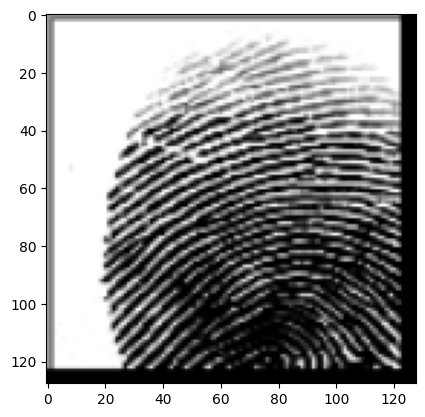

In [5]:
img, label = dataset[0]
print(img.shape, label)
plt.imshow(img.permute(1, 2, 0))

# Training , Testing and Validiation Dataset

In [6]:
random_seed=42
torch.manual_seed(random_seed)

In [7]:
val_size = 1000
test_size = 1000
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(4000, 1000, 1000)

In [8]:
from torch.utils.data.dataloader import DataLoader

batch_size = 32

In [9]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True) # We can double the batch size

In [10]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

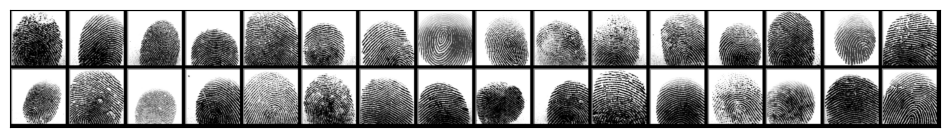

In [11]:
show_batch(train_dl)

In [12]:
for images, labels in train_dl:
    print('images shape:', images.shape)
    break

images shape: torch.Size([32, 3, 128, 128])


# Model Building

In [13]:
import torch.nn as nn
import torch.nn.functional as F

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [15]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = conv_block(in_channels, 64) #64 x 32x 32
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 16 x 16
                                  conv_block(128, 128)) # 128 x 16 x 16

        self.conv3 = conv_block(128, 256, pool=True) # 256 x 8 x 8
        self.conv4 = conv_block(256,512, pool=True) # 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), # 512 x 4 x 4
                                  conv_block(512, 512))# 512 x 4 x 4

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 512 x 1 x 1
                                        nn.Flatten(), # 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes)) # 10

    def forward(self, xb):
        out1 = self.conv1(xb)
        out2 = self.conv2(out1)
        out3 = self.res1(out2) + out2
        out4 = self.conv3(out3)
        out5 = self.conv4(out4)
        out6 = self.res2(out5) + out5
        out7 = self.classifier(out6)
        return out7


In [16]:

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [17]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [18]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [19]:
device = get_default_device()
device

device(type='cuda')

In [20]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model = to_device(ResNet9(3, 8), device)
model


ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [21]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()##gradient calculation

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [22]:
evaluate(model, val_dl)

{'val_loss': 2.0810251235961914, 'val_acc': 0.11328125}

In [23]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
history = []

In [24]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                             grad_clip=grad_clip,
                             weight_decay=weight_decay,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00278, train_loss: 1.6742, val_loss: 1.4006, val_acc: 0.5896
Epoch [1], last_lr: 0.00759, train_loss: 1.5218, val_loss: 1.4051, val_acc: 0.5619
Epoch [2], last_lr: 0.01000, train_loss: 1.5666, val_loss: 2.6532, val_acc: 0.4799
Epoch [3], last_lr: 0.00950, train_loss: 1.1845, val_loss: 1.0713, val_acc: 0.6549
Epoch [4], last_lr: 0.00812, train_loss: 0.8780, val_loss: 1.0077, val_acc: 0.6945
Epoch [5], last_lr: 0.00611, train_loss: 0.6789, val_loss: 0.5041, val_acc: 0.8047
Epoch [6], last_lr: 0.00389, train_loss: 0.4607, val_loss: 0.3404, val_acc: 0.8490
Epoch [7], last_lr: 0.00188, train_loss: 0.3720, val_loss: 1.2075, val_acc: 0.6730
Epoch [8], last_lr: 0.00050, train_loss: 0.2895, val_loss: 0.2778, val_acc: 0.8863
Epoch [9], last_lr: 0.00000, train_loss: 0.2391, val_loss: 0.2459, val_acc: 0.8951
CPU times: user 2min 34s, sys: 2min 12s, total: 4min 46s
Wall time: 4min 43s


In [25]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

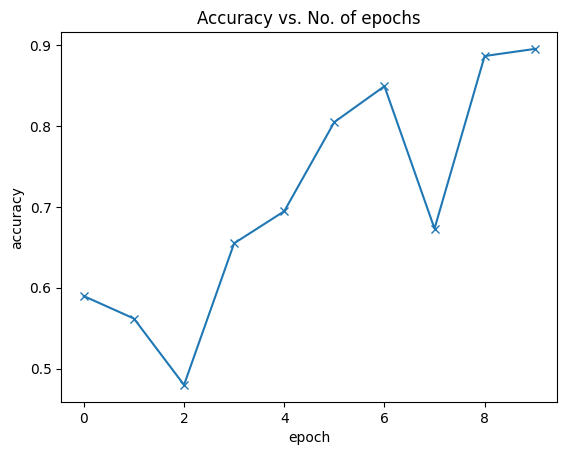

In [26]:
plot_accuracies(history)

In [27]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

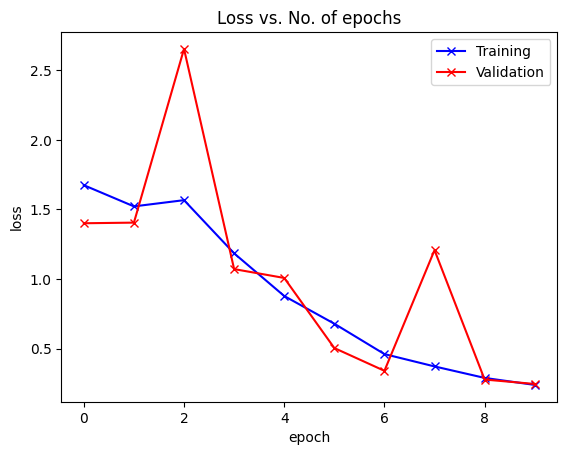

In [28]:
plot_losses(history)

In [29]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

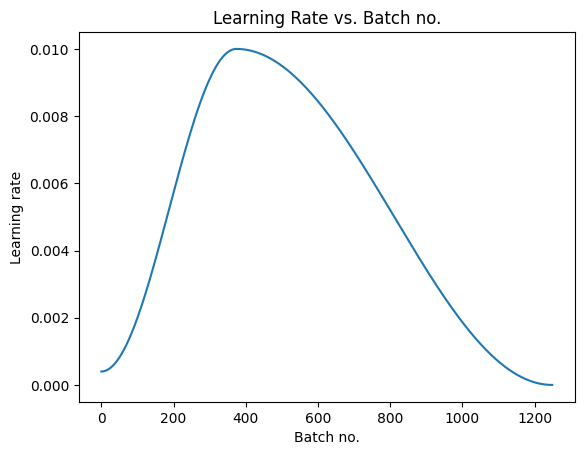

In [30]:
plot_lrs(history)

In [31]:
test_loader = DeviceDataLoader(DataLoader(test_ds, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.22808413207530975, 'val_acc': 0.9095703363418579}

In [32]:
from sklearn.metrics import classification_report

In [33]:
@torch.no_grad()
def evaluate_with_predictions(model, val_loader):
    model.eval()
    predictions, targets = [], []
    for batch in val_loader:
        images, labels = batch
        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)
        predictions.extend(preds.cpu().numpy())
        targets.extend(labels.cpu().numpy())
    return np.array(predictions), np.array(targets)

# Evaluation

In [34]:
predictions, targets = evaluate_with_predictions(model, test_loader)
print("\nClassification Report:\n")
print(classification_report(targets, predictions, target_names=dataset.classes))


Classification Report:

              precision    recall  f1-score   support

          A+       0.90      0.96      0.93        95
          A-       0.91      0.87      0.89       158
         AB+       0.93      0.90      0.91       128
         AB-       0.91      0.93      0.92       138
          B+       0.95      0.92      0.93       115
          B-       0.95      0.97      0.96       113
          O+       0.83      0.91      0.87       132
          O-       0.94      0.85      0.89       121

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



In [35]:
def visualize_predictions(model, val_loader, num_images=6):
    model.eval()
    images, labels = next(iter(val_loader))
    images, labels = images[:num_images], labels[:num_images]
    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)

    fig, axes = plt.subplots(1, num_images, figsize=(15, 6))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].permute(1, 2, 0).cpu())
        ax.set_title(f"Actual: {dataset.classes[labels[i]]}\nPredicted: {dataset.classes[preds[i]]}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

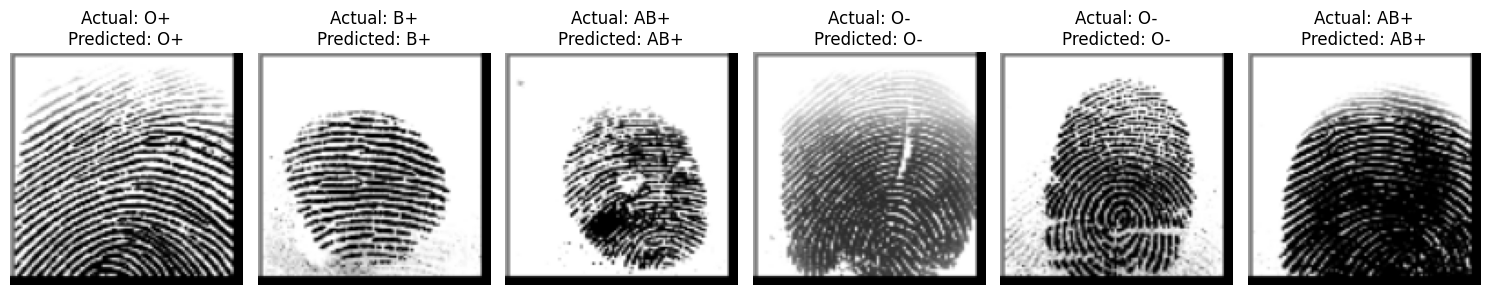

In [36]:
visualize_predictions(model, test_loader)

In [37]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: A- , Predicted: A-


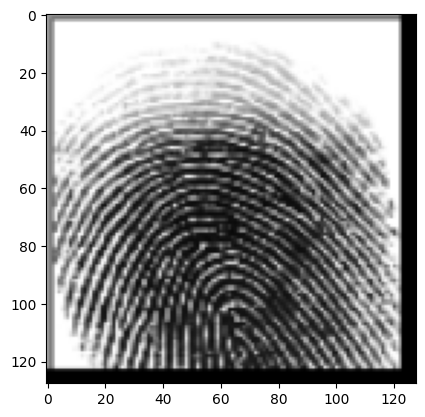

In [38]:
img, label = test_ds[179]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [39]:
torch.save(model.state_dict(), 'FingurePrintTOBloodGroup.pth')

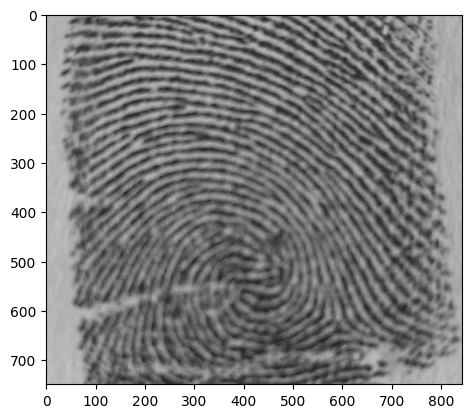

In [40]:
from PIL import Image
img = Image.open('/kaggle/input/fingure-printpatil/Patil1.jpg')
plt.imshow(img)

In [41]:
import torchvision.transforms as tt

In [42]:
transform = Compose([
    Resize((128, 128)),# Adjust the crop as per your needs
    tt.RandomHorizontalFlip(),
    ToTensor()# Convert the image to a tensor
])

# Apply the transformations to the image
img_tensor = transform(img)

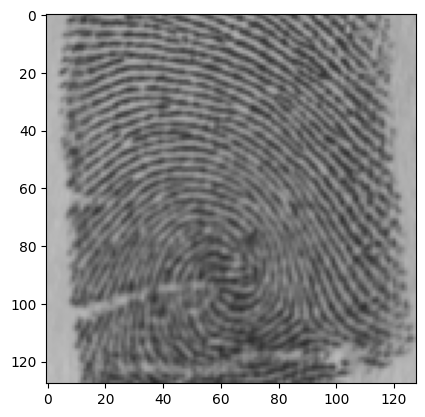

In [43]:
plt.imshow(img_tensor.permute(1, 2, 0))

In [44]:
img_tensor.shape

torch.Size([3, 128, 128])

In [45]:
res = predict_image(img_tensor, model)
res

'AB-'

# Deployment